MPGNN: Molecule Prediction with Graph Neural Networks

In [1]:
import pandas as pd
from rdkit import Chem
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

"""
!!!
NOTE: This file was replaced by dataset_featurizer.py
but is kept to illustrate how to build a custom dataset in PyG.
!!!
"""


class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Torch version: 2.0.1
Cuda available: False
Torch geometric version: 2.3.1


In [14]:
dataset = MoleculeDataset(root="./data/HIV/", filename="HIV_train_oversampled.csv")

Processing...
 27%|██▋       | 19569/71634 [01:43<04:39, 186.58it/s][16:09:35] WARNING: not removing hydrogen atom without neighbors
[16:09:35] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 71634/71634 [06:24<00:00, 186.13it/s]
Done!


In [15]:
dataset[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12, 13],
        [13, 12],
        [13, 14],
        [14, 13],
        [14, 15],
        [15, 14],
        [14, 16],
        [16, 14],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 18],
        [19, 20],
        [20, 19],
        [20, 21],
        [21, 20],
        [21, 22],
        [22, 21],
        [22, 23],
        [23, 22],
        [23, 24],
        [24, 23],
        [24, 25],
        [25, 24],
        [25, 26],
        [26, 25],
        [25, 27],
        [27, 25],
        [25, 28],
        [2

In [16]:
dataset[0].x

tensor([[ 8.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 7.,  2.,  0.,  3.,  0.,  1.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  1.,  1.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  1.,  1.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  0.,  1.,  0.,  0.,  0.],
        [ 6.,  2.,  0.,  3.,  0.,  1.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  1.,  1.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  1.,  1.,  0.,  1.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 7.,  2.,  0.,  3.,  0.,  1.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 8.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 6.,  3.,  0.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 6.,  2.,  0.,  3.,  1.,  1.,  0.,  1.,  0.],
        [ 

In [17]:
dataset[0].edge_attr

tensor([[2.0000, 0.0000],
        [2.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [2.0000, 0.0000],
        [2.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [2.0000, 0.0000],
        [2.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.5000, 1.0000],
        [1.0

In [18]:
dataset[0].y

tensor([1])

In [19]:
import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(GNN, self).__init__()
        embedding_size = model_params["model_embedding_size"]
        n_heads = model_params["model_attention_heads"]
        self.n_layers = model_params["model_layers"]
        dropout_rate = model_params["model_dropout_rate"]
        top_k_ratio = model_params["model_top_k_ratio"]
        self.top_k_every_n = model_params["model_top_k_every_n"]
        dense_neurons = model_params["model_dense_neurons"]
        edge_dim = model_params["model_edge_dim"]

        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        # Transformation layer
        self.conv1 = TransformerConv(feature_size, 
                                    embedding_size, 
                                    heads=n_heads, 
                                    dropout=dropout_rate,
                                    edge_dim=edge_dim,
                                    beta=True) 

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # Other layers
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size, 
                                                    embedding_size, 
                                                    heads=n_heads, 
                                                    dropout=dropout_rate,
                                                    edge_dim=edge_dim,
                                                    beta=True))

            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))
            

        # Linear layers
        self.linear1 = Linear(embedding_size*2, dense_neurons)
        self.linear2 = Linear(dense_neurons, int(dense_neurons/2))  
        self.linear3 = Linear(int(dense_neurons/2), 1)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.relu(self.transf1(x))
        x = self.bn1(x)

        # Holds the intermediate graph representations
        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x))
            x = self.bn_layers[i](x)
            # Always aggregate last layer
            if i % self.top_k_every_n == 0 or i == self.n_layers:
                x , edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[int(i/self.top_k_every_n)](
                    x, edge_index, edge_attr, batch_index
                    )
                # Add current representation
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))
    
        x = sum(global_representation)

        # Output block
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = torch.relu(self.linear2(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear3(x)

        return x

conv.TransformerConv: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.TransformerConv.html#torch_geometric.nn.conv.TransformerConv 
To check other layers: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html

Transformer is a transduction model. These models are a type of neural network that processes an input sequence and generates an output sequence. They are used in machine learning and are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism.

Transformer has an encoder-decoder structureth, where encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn). Given z, the decoder then generates an output sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

heads: Number of multi-head-attentions. Multi-head attention is used to allow the model to jointly attend to information from different representation sub-spaces at different viewpoints. In practice, given the same set of queries, keys, and values (for example, query: node1, key: node2, value: edge value between node1 and node2 sets could be node features) we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (e.g., dependencies between nodes with different distances, like neighbor nodes or nodes connected with a 3-hop path) within a sequence. Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values. To this end, instead of performing a single attention pooling, queries, keys, and values can be transformed with h independently learned linear projections. Then these h projected queries, keys, and values are fed into attention pooling in parallel. In the end, h attention pooling outputs are concatenated and transformed with another learned linear projection to produce the final output. This design is called multi-head attention, where each of the h attention pooling outputs is a head. For more details see the following links:
- https://d2l.djl.ai/chapter_attention-mechanisms/multihead-attention.html
- Attention is all you need: https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
- GNN Project #3.2 - Graph Transformer

dropout: Dropout probability of the normalized attention coefficients which exposes each node to a stochastically sampled neighborhood during training. (default: 0)

beta: It enables some weighted aggregation.

TopKPooling: Keeping K nodes of the input graph for another round of message passing and aggregation.

In [48]:
import numpy as np
# from mlflow.models.signature import ModelSignature
# from mlflow.types.schema import Schema, TensorSpec

BEST_PARAMETERS = {
    "batch_size": 128,
    "learning_rate": 0.01,
    "weight_decay": 0.0001,
    "sgd_momentum": 0.8,
    "scheduler_gamma": 0.8,
    "pos_weight": 1.3,
    "model_embedding_size": 64,
    "model_attention_heads": 3,
    "model_layers": 4,
    "model_dropout_rate": 0.2,
    "model_top_k_ratio": 0.5,
    "model_top_k_every_n": 10,
    "model_dense_neurons": 256
}

# input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 30), name="x"), 
#                        TensorSpec(np.dtype(np.float32), (-1, 11), name="edge_attr"), 
#                        TensorSpec(np.dtype(np.int32), (2, -1), name="edge_index"), 
#                        TensorSpec(np.dtype(np.int32), (-1, 1), name="batch_index")])

# output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1))])

# SIGNATURE = ModelSignature(inputs=input_schema, outputs=output_schema)

Loading dataset...
Loading model...
Number of parameters: 340673


100%|██████████| 560/560 [01:38<00:00,  5.69it/s]



 Confusion matrix: 
 [[10318  6478]
 [25532 29306]]
F1 Score: 0.6467745139149433
Accuracy: 0.5531451545355558
Precision: 0.5344104453116452
Recall: 0.8189693717862732
ROC AUC: 0.5533898462836526
Epoch 0 | Train Loss 0.7609472795256547
[[0.44718498]
 [0.44742325]
 [0.46465796]
 [0.5130902 ]
 [0.4682292 ]
 [0.4564873 ]
 [0.4450713 ]
 [0.5505295 ]
 [0.44805464]
 [0.46213028]]
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
[0 0 0 0 0 0 0 0 0 0]

 Confusion matrix: 
 [[3172   79]
 [ 662   86]]
F1 Score: 0.18838992332968235
Accuracy: 0.8147036759189797
Precision: 0.11497326203208556
Recall: 0.5212121212121212
ROC AUC: 0.6742732489211363


FileNotFoundError: [Errno 2] No such file or directory: 'data/HIV/images/cm_0.png'

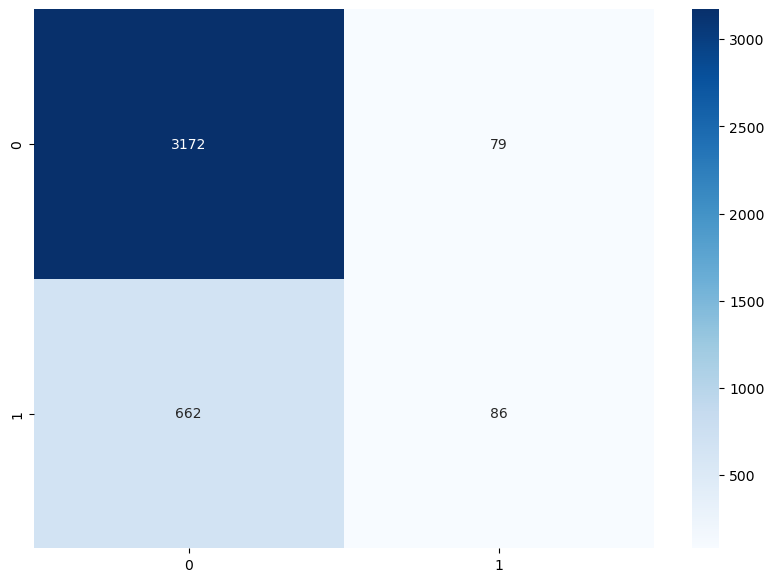

In [50]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
# import mlflow.pytorch
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        # Calculating the loss and gradients
        loss = loss_fn(torch.squeeze(pred), batch.y.float())
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss/step

def test(epoch, model, test_loader, loss_fn):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = loss_fn(torch.squeeze(pred), batch.y.float())

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_preds_raw.append(torch.sigmoid(pred).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    print(all_preds_raw[0][:10])
    print(all_preds[:10])
    print(all_labels[:10])
    calculate_metrics(all_preds, all_labels, epoch, "test")
    log_conf_matrix(all_preds, all_labels, epoch)
    return running_loss/step

def log_conf_matrix(y_pred, y_true, epoch):
    # Log confusion matrix as image
    cm = confusion_matrix(y_pred, y_true)
    classes = ["0", "1"]
    df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
    cfm_plot.figure.savefig(f'data/HIV/images/cm_{epoch}.png')
    # mlflow.log_artifact(f"data/images/cm_{epoch}.png")

def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    # mlflow.log_metric(key=f"Precision-{type}", value=float(prec), step=epoch)
    # mlflow.log_metric(key=f"Recall-{type}", value=float(rec), step=epoch)
    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
        # mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        # mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")

def run_one_training(params):
    params = params[0]
    # with mlflow.start_run() as run:
    # Log parameters used in this experiment
    # for key in params.keys():
    #     mlflow.log_param(key, params[key])

    # Loading the dataset
    print("Loading dataset...")
    train_dataset = MoleculeDataset(root="data/HIV/", filename="HIV_train_oversampled.csv")
    test_dataset = MoleculeDataset(root="data/HIV/", filename="HIV_test.csv", test=True)
    params["model_edge_dim"] = train_dataset[0].edge_attr.shape[1]

    # Prepare training
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=True)

    # Loading the model
    print("Loading model...")
    model_params = {k: v for k, v in params.items() if k.startswith("model_")}
    model = GNN(feature_size=train_dataset[0].x.shape[1], model_params=model_params) 
    model = model.to(device)
    print(f"Number of parameters: {count_parameters(model)}")
    # mlflow.log_param("num_params", count_parameters(model))


    # < 1 increases precision, > 1 recall
    weight = torch.tensor([params["pos_weight"]], dtype=torch.float32).to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=params["learning_rate"],
                                momentum=params["sgd_momentum"],
                                weight_decay=params["weight_decay"])
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])
    
    # Start training
    best_loss = 1000
    early_stopping_counter = 0
    for epoch in range(300): 
        if early_stopping_counter <= 10: # = x * 5 
            # Training
            model.train()
            loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
            print(f"Epoch {epoch} | Train Loss {loss}")
            # mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

            # Testing
            model.eval()
            if epoch % 5 == 0:
                loss = test(epoch, model, test_loader, loss_fn)
                print(f"Epoch {epoch} | Test Loss {loss}")
                # mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                
                # Update best loss
                if float(loss) < best_loss:
                    best_loss = loss
                    # Save the currently best model 
                    # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

            # scheduler.step()
        else:
            print("Early stopping due to no improvement.")
            return [best_loss]
    print(f"Finishing training with best test loss: {best_loss}")
    return [best_loss]

run_one_training([BEST_PARAMETERS])